
# **Seguidor Solar de 2 GDL — EPN**  
**Autor:** Matthew Cedeño  

**Fecha de generación del cuaderno:** 2025-08-10 05:19

> Cuaderno limpio y portable para calcular los **ángulos de control** (*roll* y *pitch*) de un seguidor solar biaxial (ejes **Norte** y **Este**), simular un día completo, graficar series temporales y generar una **animación** corta (≤ 30 s).



## 1) Resumen y objetivos *(Celda 2)*
- Calcular posición solar local (**azimut** α, **elevación** θ) para lat/lon y fecha dados (zona horaria **America/Guayaquil**).
- Convertir (α, θ) → (**roll**, **pitch**) con la cinemática del seguidor de la EPN (ejes **N** y **E**).
- Simular un intervalo horario (p. ej., un día) con paso en minutos.
- Graficar **azimut**, **elevación**, **roll** y **pitch**.
- Dibujar una animación 3D corta (GIF) mostrando el **panel** y el **vector solar**.



## 2) Convenciones y derivación *(Celda 3)*

**Sistema local ENU:** E (Este, +x), N (Norte, +y), U (Arriba, +z).  
**Convención de azimut:** medido desde el **Norte** en sentido horario: N=0°, E=90°, S=180°, O=270°.  
**Elevación** θ: ángulo sobre el horizonte (−90° a 90°).

Vector unitario del Sol en ENU, usando (α, θ):  
\[
E=\cos\theta\ \sin\alpha,\quad
N=\cos\theta\ \cos\alpha,\quad
U=\sin\theta.
\]

El seguidor rota:
- **pitch (φ)** alrededor del eje **Este (+x)**,
- **roll (ρ)** alrededor del eje **Norte (+y)**,
- con normal inicial del panel \( \mathbf{n}_0=[0,0,1] \).

Aplicando \( \mathbf{n} = R_y(\rho)\, R_x(\phi)\, \mathbf{n}_0 \) y alineando con el Sol \((E,N,U)\), se obtienen:
\[
\rho = \operatorname{atan2}(E,\, U),\qquad
\phi = \operatorname{atan2}(-N,\, \sqrt{E^2+U^2}).
\]

Estas expresiones usan **atan2** para estabilidad numérica cerca del horizonte.


In [ ]:

# 3) Imports y configuración *(Celda 4)*
from __future__ import annotations
from dataclasses import dataclass
from datetime import datetime, timedelta
from math import sin, cos, tan, atan2, asin, acos, radians, degrees, sqrt, hypot, pi
from zoneinfo import ZoneInfo
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.animation import FuncAnimation, PillowWriter

# No fijamos estilos ni colores específicos (recomendación del proyecto)
TZ = ZoneInfo("America/Guayaquil")

# Salidas portables en la carpeta 'salidas' junto al cuaderno en ejecución
OUTDIR = Path(r"C:/Users/Matthew/Desktop/Metodos/SeguidorSolar/salidas")
OUTDIR.mkdir(parents=True, exist_ok=True)

LAT_EPN = -0.2105367
LON_EPN = -78.491614



## 3) Posición solar (NOAA, sin dependencias) *(Celda 5)*
Implementación compacta y suficiente para simulación académica. Calcula **azimut (°)** y **elevación (°)** para una fecha-hora local con TZ.


In [2]:

# 5) Posición solar (NOAA simplificado)
# Referencia: algoritmo público NOAA (versión compacta). Exactitud suficiente para visualización/seguimiento académico.
def solar_position_noaa(dt_local: datetime, lat: float, lon: float) -> tuple[float, float]:
    """Retorna (azimuth_deg, elevation_deg) con azimut desde el Norte (horario) y elevación sobre el horizonte."""
    # Convertir a UTC y calcular fracción del día
    if dt_local.tzinfo is None:
        raise ValueError("dt_local debe tener zona horaria (tz-aware).")
    dt_utc = dt_local.astimezone(ZoneInfo("UTC"))
    # Día juliano
    y = dt_utc.year
    m = dt_utc.month
    d = dt_utc.day + (dt_utc.hour + dt_utc.minute/60 + dt_utc.second/3600)/24
    if m <= 2:
        y -= 1
        m += 12
    A = int(y/100)
    B = 2 - A + int(A/4)
    JD = int(365.25*(y+4716)) + int(30.6001*(m+1)) + d + B - 1524.5
    T = (JD - 2451545.0) / 36525.0

    # Coordenadas solares básicas
    L0 = (280.46646 + 36000.76983*T + 0.0003032*T*T) % 360
    M  = 357.52911 + 35999.05029*T - 0.0001537*T*T
    e  = 0.016708634 - 0.000042037*T - 0.0000001267*T*T
    Mr = radians(M)
    C  = (1.914602 - 0.004817*T - 0.000014*T*T)*sin(Mr) + (0.019993 - 0.000101*T)*sin(2*Mr) + 0.000289*sin(3*Mr)
    true_long = L0 + C
    omega = 125.04 - 1934.136*T
    lambda_sun = true_long - 0.00569 - 0.00478*sin(radians(omega))

    eps0 = 23 + (26 + ((21.448 - T*(46.815 + T*(0.00059 - 0.001813*T))))/60)/60
    eps = eps0 + 0.00256*cos(radians(omega))
    epsr = radians(eps)
    lambdar = radians(lambda_sun)

    # Declinación solar
    delta = degrees(asin(sin(epsr)*sin(lambdar)))

    # Ecuación del tiempo (min)
    y_e = tan(epsr/2); y_e *= y_e
    EoT = 4*degrees(y_e*sin(2*radians(L0)) - 2*e*sin(Mr) + 4*e*y_e*sin(Mr)*cos(2*radians(L0)) - 0.5*y_e*y_e*sin(4*radians(L0)) - 1.25*e*e*sin(2*Mr))

    # Hora solar verdadera (HRA)
    # Nota: la longitud al Oeste (Ecuador) es negativa -> signo correcto en la corrección de longitud
    time_offset = EoT + 4*lon  # en minutos
    tst = ((dt_local.hour*60 + dt_local.minute + dt_local.second/60) + time_offset) % 1440
    HRA = (tst/4) - 180  # grados

    # Alt/az
    latr = radians(lat)
    deltar = radians(delta)
    HRAr = radians(HRA)

    cos_zenith = sin(latr)*sin(deltar) + cos(latr)*cos(deltar)*cos(HRAr)
    cos_zenith = max(-1.0, min(1.0, cos_zenith))
    zenith = degrees(acos(cos_zenith))
    elevation = 90 - zenith

    # Azimuth desde el Sur CCW -> convertimos a desde el Norte horario
    az_south_ccw = degrees(atan2(sin(HRAr), cos(HRAr)*sin(latr) - tan(deltar)*cos(latr)))
    az_north_cw = (az_south_ccw + 180) % 360

    return az_north_cw, elevation



## 4) Conversión (α, θ) → (roll, pitch) *(Celda 6)*
Funciones numéricas estables, con política de parqueo nocturno y opción de saturación mecánica.


In [3]:

# 6) Conversión solar -> ángulos del seguidor
def solar_to_panel_angles(az_deg: float, el_deg: float, pitch_limits=None, roll_limits=None):
    """Convierte (azimut, elevación) a (roll, pitch) en grados.
    - azimut desde el Norte horario
    - elevación sobre el horizonte
    - pitch_limits=(min,max), roll_limits=(min,max) opcionales
    - política: si el <= 0 -> retorna (None, None)
    """
    if el_deg <= 0:
        return None, None

    az = radians(az_deg)
    el = radians(el_deg)

    E = cos(el)*sin(az)
    N = cos(el)*cos(az)
    U = sin(el)

    roll  = degrees(atan2(E, U))
    pitch = degrees(atan2(-N, hypot(E, U)))

    if roll_limits is not None and roll is not None:
        roll = max(roll_limits[0], min(roll_limits[1], roll))
    if pitch_limits is not None and pitch is not None:
        pitch = max(pitch_limits[0], min(pitch_limits[1], pitch))
    return roll, pitch



## 5) Simulación de un día *(Celda 7)*
Construye un `DataFrame` con tiempos, posición solar y ángulos de control.


In [4]:

# 7) Simular intervalo
def simular_intervalo(
    fecha_str: str = None,
    hora_inicio: str = "06:00",
    hora_fin: str = "18:00",
    lat: float = LAT_EPN,
    lon: float = LON_EPN,
    paso_min: int = 10,
    pitch_limits=(-60, 60),
    roll_limits=(-180, 180),
    tz: ZoneInfo = TZ
) -> pd.DataFrame:
    """Devuelve DataFrame con columnas: datetime_local, azimuth_deg, elevation_deg, roll_deg, pitch_deg."""
    if fecha_str is None:
        fecha_str = datetime.now(tz).strftime("%Y-%m-%d")
    dt_inicio = datetime.strptime(f"{fecha_str} {hora_inicio}", "%Y-%m-%d %H:%M").replace(tzinfo=tz)
    dt_fin    = datetime.strptime(f"{fecha_str} {hora_fin}", "%Y-%m-%d %H:%M").replace(tzinfo=tz)
    if dt_fin <= dt_inicio:
        raise ValueError("La hora fin debe ser posterior a la hora inicio.")
    if paso_min <= 0:
        raise ValueError("El paso (min) debe ser > 0.")

    tiempos = []
    azs, els, rolls, pitchs = [], [], [], []
    dt = dt_inicio
    while dt <= dt_fin:
        az, el = solar_position_noaa(dt, lat, lon)
        r, p = solar_to_panel_angles(az, el, pitch_limits=pitch_limits, roll_limits=roll_limits)
        tiempos.append(dt)
        azs.append(az); els.append(el)
        rolls.append(r); pitchs.append(p)
        dt += timedelta(minutes=paso_min)

    df = pd.DataFrame({
        "datetime_local": tiempos,
        "azimuth_deg": azs,
        "elevation_deg": els,
        "roll_deg": rolls,
        "pitch_deg": pitchs,
    })
    return df



## 6) Gráficas *(Celda 8)*
Una figura por variable (sin estilos específicos).


In [5]:

# 8) Gráficas simples (una por figura)
def plot_series(df: pd.DataFrame, fecha_label: str = ""):
    dfx = df.dropna(subset=["pitch_deg", "roll_deg"])

    plt.figure()
    plt.plot(df["datetime_local"], df["elevation_deg"])
    plt.title(f"Elevación solar {fecha_label}")
    plt.xlabel("Tiempo local")
    plt.ylabel("Elevación (°)")
    plt.tight_layout()

    plt.figure()
    plt.plot(df["datetime_local"], df["azimuth_deg"])
    plt.title(f"Azimut solar {fecha_label}")
    plt.xlabel("Tiempo local")
    plt.ylabel("Azimut (°)")
    plt.tight_layout()

    plt.figure()
    plt.plot(dfx["datetime_local"], dfx["pitch_deg"])
    plt.title(f"Pitch del panel {fecha_label}")
    plt.xlabel("Tiempo local")
    plt.ylabel("Pitch (°)")
    plt.tight_layout()

    plt.figure()
    plt.plot(dfx["datetime_local"], dfx["roll_deg"])
    plt.title(f"Roll del panel {fecha_label}")
    plt.xlabel("Tiempo local")
    plt.ylabel("Roll (°)")
    plt.tight_layout()



## 7) Visual 3D y animación *(Celda 9)*
Genera un **GIF** (siempre disponible con `PillowWriter`). El MP4 con `ffmpeg` se puede activar localmente.


In [6]:

# 9) Utilidades 3D
import numpy as np

def solar_vector_ENU(az_deg: float, el_deg: float):
    az = radians(az_deg); el = radians(el_deg)
    E = cos(el)*sin(az); N = cos(el)*cos(az); U = sin(el)
    return np.array([E, N, U], dtype=float)

def panel_normal_from_angles(roll_deg: float, pitch_deg: float):
    # n = Ry(roll) Rx(pitch) [0,0,1]^T
    r = radians(roll_deg); p = radians(pitch_deg)
    # Rotación Rx(p): sobre x (E)
    Rx = np.array([[1, 0, 0],
                   [0,  cos(p), -sin(p)],
                   [0,  sin(p),  cos(p)]], float)
    # Rotación Ry(r): sobre y (N)
    Ry = np.array([[ cos(r), 0, sin(r)],
                   [ 0,       1, 0     ],
                   [-sin(r), 0, cos(r)]], float)
    n0 = np.array([0,0,1.0])
    n = Ry @ (Rx @ n0)
    return n

def panel_quad_vertices(n: np.ndarray, size=0.6, thickness=0.02):
    # Aproxima un panel centrado en el origen perpendicular a n
    n = n / np.linalg.norm(n)
    # ejes locales del panel (u,v) ortogonales a n
    up = np.array([0,0,1.0])
    if abs(np.dot(up, n)) > 0.9:  # si casi paralelo, cambia vector base
        up = np.array([1,0,0.0])
    u = np.cross(n, up); u /= np.linalg.norm(u)
    v = np.cross(n, u);  v /= np.linalg.norm(v)

    half = size/2
    corners = [
        -half*u - half*v,
        +half*u - half*v,
        +half*u + half*v,
        -half*u + half*v,
    ]
    # cara posterior (opcional espesor)
    back = [c - thickness*n for c in corners]
    return corners, back

def animar_3d(df: pd.DataFrame, nombre_base: str, max_seg=30, fps=12):
    dfx = df.dropna(subset=["pitch_deg", "roll_deg"]).reset_index(drop=True)
    if len(dfx) == 0:
        print("No hay muestras diurnas para animar.")
        return None
    frames = min(len(dfx), max_seg*fps)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel("Este (E)")
    ax.set_ylabel("Norte (N)")
    ax.set_zlabel("Arriba (U)")
    ax.set_xlim(-1, 1); ax.set_ylim(-1, 1); ax.set_zlim(0, 1.0)
    plt.tight_layout()

    # Inicializa panel y vector solar
    n0 = panel_normal_from_angles(dfx.loc[0,"roll_deg"], dfx.loc[0,"pitch_deg"])
    front, back = panel_quad_vertices(n0)
    panel = Poly3DCollection([front, back], alpha=0.6)
    ax.add_collection3d(panel)

    sv0 = solar_vector_ENU(dfx.loc[0,"azimuth_deg"], dfx.loc[0,"elevation_deg"])
    # Usamos plot para el punto solar y quiver para la dirección
    sun_point, = ax.plot([sv0[0]], [sv0[1]], [sv0[2]], marker='o')
    sun_quiv = ax.quiver(0, 0, 0, sv0[0], sv0[1], sv0[2], length=1.0, normalize=True)

    def update(i):
        nonlocal sun_quiv  # se redefine en cada frame
        n = panel_normal_from_angles(dfx.loc[i,"roll_deg"], dfx.loc[i,"pitch_deg"])
        front, back = panel_quad_vertices(n)
        panel.set_verts([front, back])

        sv = solar_vector_ENU(dfx.loc[i,"azimuth_deg"], dfx.loc[i,"elevation_deg"])
        # actualizar punto
        sun_point.set_data([sv[0]],[sv[1]])
        sun_point.set_3d_properties([sv[2]])
        # actualizar quiver (recrear)
        sun_quiv.remove()
        sun_quiv = ax.quiver(0,0,0, sv[0],sv[1],sv[2], length=1.0, normalize=True)

        ax.set_title(dfx.loc[i, "datetime_local"].strftime("Hora local: %H:%M"))
        return panel, sun_point, sun_quiv

    ani = FuncAnimation(fig, update, frames=frames, interval=int(1000/fps))
    out_path = OUTDIR / f"{nombre_base}.gif"
    ani.save(out_path, writer=PillowWriter(fps=fps))
    plt.close(fig)
    print("GIF generado:", out_path)
    return out_path



## 8) Validación (panel ⟂ a la luz) *(Celda 10)*
El producto punto entre la normal del panel y el vector solar debería estar **cerca de 1**.


In [7]:

# 10) Validación
def validar_dot(df: pd.DataFrame) -> pd.DataFrame:
    dfx = df.dropna(subset=["pitch_deg", "roll_deg"]).copy()
    dots = []
    for _, row in dfx.iterrows():
        n = panel_normal_from_angles(row["roll_deg"], row["pitch_deg"])
        s = solar_vector_ENU(row["azimuth_deg"], row["elevation_deg"])
        n /= np.linalg.norm(n); s /= np.linalg.norm(s)
        dots.append(float(np.dot(n, s)))
    dfx["dot_ns"] = dots
    return dfx



## 9) Ejecución de ejemplo *(Celda 11)*
Ajusta la `fecha`, `hora_inicio`, `hora_fin` y `paso_min`.  
Se guardan CSV y GIF en la carpeta `salidas/`.


CSV guardado en: c:\Users\Matthew\Desktop\Metodos\SeguidorSolar\salidas\sim_2025-08-10.csv
dot(ns) -> min: 1.0  | max: 1.0000000000000002
GIF generado: c:\Users\Matthew\Desktop\Metodos\SeguidorSolar\salidas\anim_seguidor_2025-08-10.gif
Listo. Revisa la carpeta: c:\Users\Matthew\Desktop\Metodos\SeguidorSolar\salidas


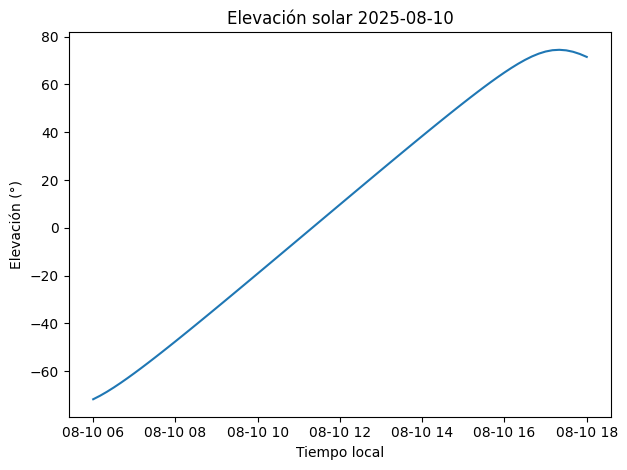

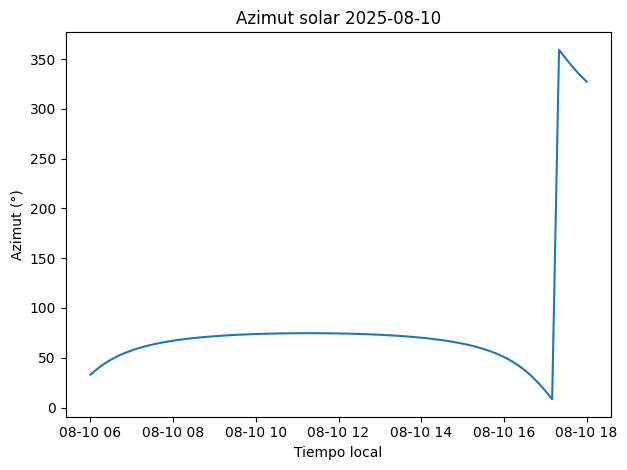

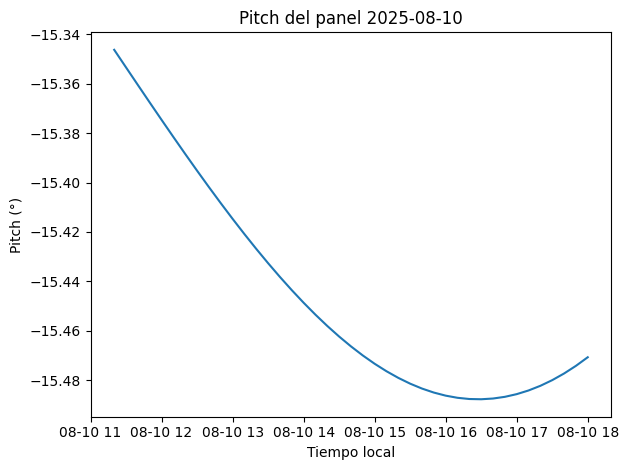

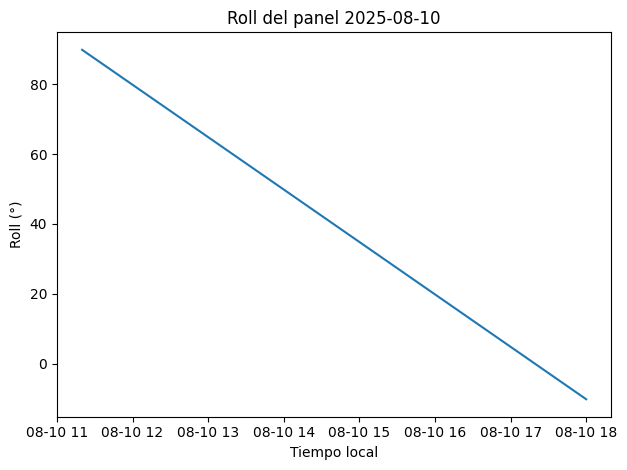

In [8]:

# 11) Ejecutar ejemplo del día actual
FECHA = datetime.now(TZ).strftime("%Y-%m-%d")
df = simular_intervalo(
    fecha_str=FECHA,
    hora_inicio="06:00",
    hora_fin="18:00",
    lat=LAT_EPN, lon=LON_EPN,
    paso_min=10,
    pitch_limits=(-60, 60),
    roll_limits=(-180, 180),
    tz=TZ
)
csv_path = OUTDIR / f"sim_{FECHA}.csv"
df.to_csv(csv_path, index=False)
print("CSV guardado en:", csv_path)

# Graficar (una figura por variable)
plot_series(df, fecha_label=FECHA)

# Validación y animación
val = validar_dot(df)
if len(val) > 0:
    print("dot(ns) -> min:", val["dot_ns"].min(), " | max:", val["dot_ns"].max())
gif_path = animar_3d(df, nombre_base=f"anim_seguidor_{FECHA}", max_seg=20, fps=12)
print("Listo. Revisa la carpeta:", OUTDIR)
